In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
from tqdm.notebook import tqdm

# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torchviz import make_dot

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

## GPUの利用

In [2]:
# デバイスの割り当て
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## データ準備

In [3]:
# ダウンロード先ディレクトリ名
data_root = './ignore_dir/data'

train_set0 = datasets.MNIST(
    # 元データダウンロー先の指定
    root = data_root,
    # 訓練データか検証データか
    train = True,
    # 元データがない場合にダウンロードするか
    download = True
)

In [4]:
# データ件数の確認
print('データ件数: ', len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解データの型: ', type(label))

データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解データの型:  <class 'int'>


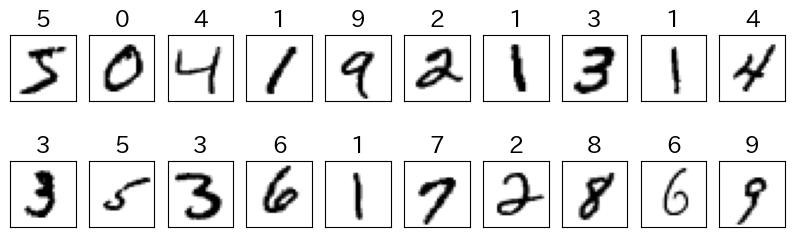

In [5]:
# 正解データ付きで、最初の20個のイメージ表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    # imageとlabelの取得
    image, label = train_set0[i]

    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 前処理（Transforms）
- Imageをテンソル化
- [0, 1]の範囲の値を[-1, 1]の範囲にする
- データのshapeを[1, 28, 28]から[784]に変換

In [6]:
# データ変換用関数 Transforms
transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),

    # (2) データの正規化
    transforms.Normalize((0.5,), (0.5,)),

    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

In [7]:
# 訓練データセットの定義
train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

# 検証データセットの定義
test_set = datasets.MNIST(
    root=data_root, train=False, download=True, transform=transform
)

In [8]:
# 変換変換結果の確認
image, label = train_set[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


## データローダーによるミニバッチ用データ生成

In [9]:
# ミニバッチのサイズ指定
batch_size = 500

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)

In [10]:
# 何組のデータが取得できるか
print(len(train_loader))

# データローダーから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


## モデル定義
- 入力層:784, 隠れ層1:128, 隠れ層2:128, 出力層:10

In [11]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10
n_output = 10

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f"n_input: {n_input} n_hidden: {n_hidden} n_output: {n_output}")

n_input: 784 n_hidden: 128 n_output: 10


#### ポイント
- 線形層(nn.Linear)が増えた
- 2層目（出力層）の線形関数の出力に対して活性化関数がない（前章と同じ）
    - 損失関数側にsoftmax関数も含める予定だから
- 以前は重みの初期値を1.0にしていたが、今回は乱数を使った最適な初期値にしている
    - パラメータ数が増えると、うまく学習できなくなるから。

In [12]:
# モデルの定義
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [13]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデル変数の生成
net = Net2(n_input, n_output, n_hidden)

# モデルをGPUに送る
net = net.to(device)

### 最適化アルゴリズム定義と損失関数定義

In [14]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

### モデル確認

In [15]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [16]:
# モデルの概要表示
print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


## メインループ

In [17]:
# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history = np.zeros((0, 5))

In [18]:
# 繰り返し計算のメインループ
for epoch in range(num_epochs):
    # 1エポック当たりの正解数（精度計算用）
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの類型損失（平均化前）
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        # 1バッチあたりのデータ件数
        train_batch_size = len(labels)
        # 1エポックあたりのデータ累積件数
        n_train += train_batch_size

        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()

        # パラメータ更新
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        train_loss += loss.item() * train_batch_size 
        n_train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        # 1バッチあたりのデータ件数
        test_batch_size = len(labels_test)
        # 1エポックあたりのデータ累積件数
        n_test += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        # 予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        val_loss += loss_test.item() * test_batch_size
        n_val_acc += (predicted_test == labels_test).sum().item()

    # 精度計算
    train_acc = n_train_acc / n_train
    val_acc   = n_val_acc / n_test
    # 損失計算
    ave_train_loss = train_loss / n_train
    ave_val_loss   = val_loss / n_test
    # 結果表示
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {ave_val_loss:.5f}, Val_acc: {val_acc:.5f}')
    # 記録
    item = np.array([epoch+1, ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/200], loss: 2.20163, acc: 0.25380, val_loss: 2.04576, Val_acc: 0.49800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/200], loss: 1.75820, acc: 0.60443, val_loss: 1.39273, Val_acc: 0.68680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/200], loss: 1.11285, acc: 0.75645, val_loss: 0.86511, Val_acc: 0.80810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/200], loss: 0.75171, acc: 0.82293, val_loss: 0.63478, Val_acc: 0.84400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/200], loss: 0.59031, acc: 0.84987, val_loss: 0.52463, Val_acc: 0.86360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/200], loss: 0.50672, acc: 0.86652, val_loss: 0.46400, Val_acc: 0.87440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/200], loss: 0.45680, acc: 0.87540, val_loss: 0.42149, Val_acc: 0.88560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/200], loss: 0.42335, acc: 0.88192, val_loss: 0.39551, Val_acc: 0.89020


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/200], loss: 0.39965, acc: 0.88768, val_loss: 0.37600, Val_acc: 0.89360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/200], loss: 0.38195, acc: 0.89185, val_loss: 0.35886, Val_acc: 0.89880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/200], loss: 0.36794, acc: 0.89477, val_loss: 0.34926, Val_acc: 0.90350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/200], loss: 0.35633, acc: 0.89805, val_loss: 0.33760, Val_acc: 0.90400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/200], loss: 0.34649, acc: 0.89965, val_loss: 0.32775, Val_acc: 0.90580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/200], loss: 0.33814, acc: 0.90202, val_loss: 0.32063, Val_acc: 0.90760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/200], loss: 0.33042, acc: 0.90460, val_loss: 0.31806, Val_acc: 0.90760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/200], loss: 0.32382, acc: 0.90602, val_loss: 0.31015, Val_acc: 0.91130


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/200], loss: 0.31777, acc: 0.90758, val_loss: 0.30470, Val_acc: 0.91140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/200], loss: 0.31206, acc: 0.90908, val_loss: 0.30014, Val_acc: 0.91400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/200], loss: 0.30685, acc: 0.91078, val_loss: 0.29440, Val_acc: 0.91420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/200], loss: 0.30213, acc: 0.91208, val_loss: 0.29148, Val_acc: 0.91500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/200], loss: 0.29752, acc: 0.91372, val_loss: 0.28591, Val_acc: 0.91640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/200], loss: 0.29327, acc: 0.91497, val_loss: 0.28178, Val_acc: 0.91750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/200], loss: 0.28876, acc: 0.91610, val_loss: 0.27957, Val_acc: 0.91850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/200], loss: 0.28524, acc: 0.91682, val_loss: 0.27462, Val_acc: 0.92080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/200], loss: 0.28128, acc: 0.91827, val_loss: 0.27168, Val_acc: 0.92150


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/200], loss: 0.27770, acc: 0.91927, val_loss: 0.26890, Val_acc: 0.92200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/200], loss: 0.27409, acc: 0.92005, val_loss: 0.26614, Val_acc: 0.92380


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/200], loss: 0.27078, acc: 0.92118, val_loss: 0.26244, Val_acc: 0.92470


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/200], loss: 0.26758, acc: 0.92228, val_loss: 0.26265, Val_acc: 0.92320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/200], loss: 0.26482, acc: 0.92290, val_loss: 0.25894, Val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/200], loss: 0.26133, acc: 0.92370, val_loss: 0.25497, Val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/200], loss: 0.25841, acc: 0.92470, val_loss: 0.25226, Val_acc: 0.92760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/200], loss: 0.25550, acc: 0.92572, val_loss: 0.25111, Val_acc: 0.92570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/200], loss: 0.25278, acc: 0.92638, val_loss: 0.24732, Val_acc: 0.92780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/200], loss: 0.24958, acc: 0.92753, val_loss: 0.24457, Val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/200], loss: 0.24675, acc: 0.92832, val_loss: 0.24469, Val_acc: 0.92770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/200], loss: 0.24409, acc: 0.92963, val_loss: 0.24131, Val_acc: 0.92840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/200], loss: 0.24157, acc: 0.93010, val_loss: 0.23740, Val_acc: 0.93200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/200], loss: 0.23885, acc: 0.93115, val_loss: 0.23471, Val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/200], loss: 0.23616, acc: 0.93165, val_loss: 0.23367, Val_acc: 0.93230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/200], loss: 0.23373, acc: 0.93217, val_loss: 0.22985, Val_acc: 0.93320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/200], loss: 0.23094, acc: 0.93277, val_loss: 0.22862, Val_acc: 0.93260


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/200], loss: 0.22848, acc: 0.93408, val_loss: 0.22666, Val_acc: 0.93570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/200], loss: 0.22611, acc: 0.93482, val_loss: 0.22330, Val_acc: 0.93510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/200], loss: 0.22343, acc: 0.93503, val_loss: 0.22105, Val_acc: 0.93450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/200], loss: 0.22103, acc: 0.93578, val_loss: 0.21978, Val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/200], loss: 0.21871, acc: 0.93688, val_loss: 0.21705, Val_acc: 0.93650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/200], loss: 0.21631, acc: 0.93758, val_loss: 0.21632, Val_acc: 0.93730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/200], loss: 0.21396, acc: 0.93833, val_loss: 0.21385, Val_acc: 0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/200], loss: 0.21179, acc: 0.93888, val_loss: 0.21025, Val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/200], loss: 0.20944, acc: 0.93942, val_loss: 0.20929, Val_acc: 0.93870


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/200], loss: 0.20723, acc: 0.94017, val_loss: 0.20952, Val_acc: 0.93590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/200], loss: 0.20505, acc: 0.94085, val_loss: 0.20476, Val_acc: 0.94070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/200], loss: 0.20265, acc: 0.94138, val_loss: 0.20285, Val_acc: 0.93920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/200], loss: 0.20042, acc: 0.94232, val_loss: 0.20079, Val_acc: 0.94170


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/200], loss: 0.19843, acc: 0.94275, val_loss: 0.19839, Val_acc: 0.94210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/200], loss: 0.19652, acc: 0.94382, val_loss: 0.19671, Val_acc: 0.94180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/200], loss: 0.19421, acc: 0.94393, val_loss: 0.19493, Val_acc: 0.94230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/200], loss: 0.19226, acc: 0.94440, val_loss: 0.19376, Val_acc: 0.94290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/200], loss: 0.19031, acc: 0.94535, val_loss: 0.19108, Val_acc: 0.94340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/200], loss: 0.18842, acc: 0.94557, val_loss: 0.18997, Val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/200], loss: 0.18623, acc: 0.94677, val_loss: 0.18819, Val_acc: 0.94450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/200], loss: 0.18459, acc: 0.94675, val_loss: 0.18558, Val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/200], loss: 0.18267, acc: 0.94707, val_loss: 0.18446, Val_acc: 0.94510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/200], loss: 0.18072, acc: 0.94803, val_loss: 0.18252, Val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/200], loss: 0.17906, acc: 0.94825, val_loss: 0.18063, Val_acc: 0.94540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/200], loss: 0.17725, acc: 0.94933, val_loss: 0.17929, Val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/200], loss: 0.17530, acc: 0.94972, val_loss: 0.17714, Val_acc: 0.94670


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/200], loss: 0.17379, acc: 0.94992, val_loss: 0.17559, Val_acc: 0.94860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/200], loss: 0.17194, acc: 0.95052, val_loss: 0.17432, Val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/200], loss: 0.17030, acc: 0.95122, val_loss: 0.17265, Val_acc: 0.94840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/200], loss: 0.16848, acc: 0.95137, val_loss: 0.17089, Val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/200], loss: 0.16689, acc: 0.95195, val_loss: 0.17038, Val_acc: 0.94960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/200], loss: 0.16519, acc: 0.95255, val_loss: 0.16924, Val_acc: 0.95040


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/200], loss: 0.16374, acc: 0.95280, val_loss: 0.16797, Val_acc: 0.94960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/200], loss: 0.16228, acc: 0.95355, val_loss: 0.16561, Val_acc: 0.95140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/200], loss: 0.16059, acc: 0.95373, val_loss: 0.16512, Val_acc: 0.95150


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/200], loss: 0.15917, acc: 0.95430, val_loss: 0.16286, Val_acc: 0.95150


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/200], loss: 0.15768, acc: 0.95455, val_loss: 0.16263, Val_acc: 0.95160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/200], loss: 0.15609, acc: 0.95528, val_loss: 0.16007, Val_acc: 0.95290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/200], loss: 0.15466, acc: 0.95562, val_loss: 0.15935, Val_acc: 0.95270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/200], loss: 0.15334, acc: 0.95593, val_loss: 0.15828, Val_acc: 0.95260


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/200], loss: 0.15188, acc: 0.95638, val_loss: 0.15679, Val_acc: 0.95290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/200], loss: 0.15064, acc: 0.95693, val_loss: 0.15562, Val_acc: 0.95400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/200], loss: 0.14919, acc: 0.95718, val_loss: 0.15533, Val_acc: 0.95400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/200], loss: 0.14786, acc: 0.95773, val_loss: 0.15303, Val_acc: 0.95410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/200], loss: 0.14653, acc: 0.95788, val_loss: 0.15199, Val_acc: 0.95450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/200], loss: 0.14522, acc: 0.95833, val_loss: 0.15013, Val_acc: 0.95480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/200], loss: 0.14408, acc: 0.95882, val_loss: 0.14955, Val_acc: 0.95500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/200], loss: 0.14252, acc: 0.95917, val_loss: 0.14936, Val_acc: 0.95520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/200], loss: 0.14150, acc: 0.95972, val_loss: 0.14766, Val_acc: 0.95550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/200], loss: 0.14014, acc: 0.95965, val_loss: 0.14765, Val_acc: 0.95560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/200], loss: 0.13902, acc: 0.96017, val_loss: 0.14749, Val_acc: 0.95610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/200], loss: 0.13766, acc: 0.96065, val_loss: 0.14509, Val_acc: 0.95630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/200], loss: 0.13664, acc: 0.96090, val_loss: 0.14403, Val_acc: 0.95620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/200], loss: 0.13549, acc: 0.96140, val_loss: 0.14404, Val_acc: 0.95680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/200], loss: 0.13421, acc: 0.96170, val_loss: 0.14098, Val_acc: 0.95680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/200], loss: 0.13314, acc: 0.96210, val_loss: 0.14103, Val_acc: 0.95700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/200], loss: 0.13194, acc: 0.96248, val_loss: 0.13977, Val_acc: 0.95710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/200], loss: 0.13094, acc: 0.96288, val_loss: 0.13871, Val_acc: 0.95820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [101/200], loss: 0.12983, acc: 0.96288, val_loss: 0.13778, Val_acc: 0.95860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [102/200], loss: 0.12867, acc: 0.96333, val_loss: 0.13746, Val_acc: 0.95820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [103/200], loss: 0.12770, acc: 0.96382, val_loss: 0.13567, Val_acc: 0.95860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [104/200], loss: 0.12658, acc: 0.96400, val_loss: 0.13548, Val_acc: 0.95810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [105/200], loss: 0.12556, acc: 0.96413, val_loss: 0.13537, Val_acc: 0.95960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [106/200], loss: 0.12454, acc: 0.96452, val_loss: 0.13381, Val_acc: 0.95880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [107/200], loss: 0.12356, acc: 0.96493, val_loss: 0.13296, Val_acc: 0.95940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [108/200], loss: 0.12246, acc: 0.96542, val_loss: 0.13179, Val_acc: 0.95940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [109/200], loss: 0.12138, acc: 0.96562, val_loss: 0.13178, Val_acc: 0.95870


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [110/200], loss: 0.12066, acc: 0.96587, val_loss: 0.13062, Val_acc: 0.95960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [111/200], loss: 0.11939, acc: 0.96613, val_loss: 0.12956, Val_acc: 0.96040


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [112/200], loss: 0.11859, acc: 0.96643, val_loss: 0.12884, Val_acc: 0.96070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [113/200], loss: 0.11760, acc: 0.96640, val_loss: 0.12773, Val_acc: 0.96090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [114/200], loss: 0.11659, acc: 0.96673, val_loss: 0.12738, Val_acc: 0.96060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [115/200], loss: 0.11588, acc: 0.96742, val_loss: 0.12673, Val_acc: 0.96100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [116/200], loss: 0.11489, acc: 0.96715, val_loss: 0.12588, Val_acc: 0.96100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [117/200], loss: 0.11386, acc: 0.96782, val_loss: 0.12516, Val_acc: 0.96170


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [118/200], loss: 0.11305, acc: 0.96757, val_loss: 0.12500, Val_acc: 0.96180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [119/200], loss: 0.11223, acc: 0.96832, val_loss: 0.12354, Val_acc: 0.96190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [120/200], loss: 0.11142, acc: 0.96847, val_loss: 0.12327, Val_acc: 0.96190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [121/200], loss: 0.11046, acc: 0.96865, val_loss: 0.12312, Val_acc: 0.96280


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [122/200], loss: 0.10968, acc: 0.96898, val_loss: 0.12148, Val_acc: 0.96290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [123/200], loss: 0.10869, acc: 0.96925, val_loss: 0.12164, Val_acc: 0.96260


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [124/200], loss: 0.10769, acc: 0.96988, val_loss: 0.12057, Val_acc: 0.96260


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [125/200], loss: 0.10710, acc: 0.96980, val_loss: 0.11972, Val_acc: 0.96260


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [126/200], loss: 0.10630, acc: 0.96993, val_loss: 0.11995, Val_acc: 0.96230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [127/200], loss: 0.10541, acc: 0.97013, val_loss: 0.11888, Val_acc: 0.96320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [128/200], loss: 0.10460, acc: 0.97058, val_loss: 0.11813, Val_acc: 0.96420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [129/200], loss: 0.10396, acc: 0.97043, val_loss: 0.11779, Val_acc: 0.96360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [130/200], loss: 0.10303, acc: 0.97113, val_loss: 0.11681, Val_acc: 0.96390


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [131/200], loss: 0.10223, acc: 0.97090, val_loss: 0.11623, Val_acc: 0.96410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [132/200], loss: 0.10162, acc: 0.97117, val_loss: 0.11754, Val_acc: 0.96340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [133/200], loss: 0.10088, acc: 0.97153, val_loss: 0.11627, Val_acc: 0.96430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [134/200], loss: 0.10009, acc: 0.97188, val_loss: 0.11575, Val_acc: 0.96470


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [135/200], loss: 0.09925, acc: 0.97225, val_loss: 0.11440, Val_acc: 0.96410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [136/200], loss: 0.09865, acc: 0.97228, val_loss: 0.11456, Val_acc: 0.96480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [137/200], loss: 0.09802, acc: 0.97242, val_loss: 0.11275, Val_acc: 0.96540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [138/200], loss: 0.09725, acc: 0.97277, val_loss: 0.11280, Val_acc: 0.96550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [139/200], loss: 0.09647, acc: 0.97295, val_loss: 0.11301, Val_acc: 0.96440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [140/200], loss: 0.09577, acc: 0.97327, val_loss: 0.11177, Val_acc: 0.96520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [141/200], loss: 0.09504, acc: 0.97350, val_loss: 0.11152, Val_acc: 0.96570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [142/200], loss: 0.09447, acc: 0.97362, val_loss: 0.11026, Val_acc: 0.96720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [143/200], loss: 0.09382, acc: 0.97382, val_loss: 0.11010, Val_acc: 0.96590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [144/200], loss: 0.09308, acc: 0.97365, val_loss: 0.10956, Val_acc: 0.96700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [145/200], loss: 0.09245, acc: 0.97435, val_loss: 0.11003, Val_acc: 0.96590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [146/200], loss: 0.09182, acc: 0.97435, val_loss: 0.10807, Val_acc: 0.96730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [147/200], loss: 0.09105, acc: 0.97457, val_loss: 0.10813, Val_acc: 0.96720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [148/200], loss: 0.09048, acc: 0.97478, val_loss: 0.10740, Val_acc: 0.96680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [149/200], loss: 0.08978, acc: 0.97483, val_loss: 0.10690, Val_acc: 0.96700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [150/200], loss: 0.08937, acc: 0.97523, val_loss: 0.10693, Val_acc: 0.96680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [151/200], loss: 0.08861, acc: 0.97530, val_loss: 0.10654, Val_acc: 0.96630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [152/200], loss: 0.08808, acc: 0.97562, val_loss: 0.10535, Val_acc: 0.96810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [153/200], loss: 0.08738, acc: 0.97575, val_loss: 0.10664, Val_acc: 0.96740


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [154/200], loss: 0.08679, acc: 0.97597, val_loss: 0.10554, Val_acc: 0.96690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [155/200], loss: 0.08626, acc: 0.97603, val_loss: 0.10559, Val_acc: 0.96750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [156/200], loss: 0.08571, acc: 0.97607, val_loss: 0.10431, Val_acc: 0.96780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [157/200], loss: 0.08513, acc: 0.97645, val_loss: 0.10427, Val_acc: 0.96750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [158/200], loss: 0.08449, acc: 0.97677, val_loss: 0.10282, Val_acc: 0.96830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [159/200], loss: 0.08408, acc: 0.97660, val_loss: 0.10327, Val_acc: 0.96840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [160/200], loss: 0.08340, acc: 0.97658, val_loss: 0.10270, Val_acc: 0.96850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [161/200], loss: 0.08285, acc: 0.97675, val_loss: 0.10244, Val_acc: 0.96850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [162/200], loss: 0.08242, acc: 0.97698, val_loss: 0.10101, Val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [163/200], loss: 0.08172, acc: 0.97742, val_loss: 0.10089, Val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [164/200], loss: 0.08132, acc: 0.97732, val_loss: 0.10130, Val_acc: 0.96860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [165/200], loss: 0.08051, acc: 0.97778, val_loss: 0.10019, Val_acc: 0.96920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [166/200], loss: 0.08016, acc: 0.97763, val_loss: 0.10060, Val_acc: 0.96940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [167/200], loss: 0.07955, acc: 0.97785, val_loss: 0.09983, Val_acc: 0.96940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [168/200], loss: 0.07905, acc: 0.97830, val_loss: 0.09915, Val_acc: 0.96890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [169/200], loss: 0.07874, acc: 0.97807, val_loss: 0.09950, Val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [170/200], loss: 0.07801, acc: 0.97808, val_loss: 0.09911, Val_acc: 0.96900


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [171/200], loss: 0.07758, acc: 0.97832, val_loss: 0.09974, Val_acc: 0.96840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [172/200], loss: 0.07697, acc: 0.97895, val_loss: 0.09799, Val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [173/200], loss: 0.07660, acc: 0.97895, val_loss: 0.09786, Val_acc: 0.97010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [174/200], loss: 0.07597, acc: 0.97893, val_loss: 0.09750, Val_acc: 0.96990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [175/200], loss: 0.07566, acc: 0.97898, val_loss: 0.09695, Val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [176/200], loss: 0.07507, acc: 0.97928, val_loss: 0.09740, Val_acc: 0.96850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [177/200], loss: 0.07467, acc: 0.97923, val_loss: 0.09668, Val_acc: 0.96990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [178/200], loss: 0.07405, acc: 0.97922, val_loss: 0.09654, Val_acc: 0.96970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [179/200], loss: 0.07369, acc: 0.97963, val_loss: 0.09620, Val_acc: 0.97040


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [180/200], loss: 0.07330, acc: 0.97947, val_loss: 0.09528, Val_acc: 0.97100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [181/200], loss: 0.07273, acc: 0.97980, val_loss: 0.09566, Val_acc: 0.97010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [182/200], loss: 0.07234, acc: 0.97987, val_loss: 0.09542, Val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [183/200], loss: 0.07194, acc: 0.98002, val_loss: 0.09534, Val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [184/200], loss: 0.07141, acc: 0.98018, val_loss: 0.09478, Val_acc: 0.97020


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [185/200], loss: 0.07090, acc: 0.98020, val_loss: 0.09485, Val_acc: 0.97070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [186/200], loss: 0.07049, acc: 0.98052, val_loss: 0.09360, Val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [187/200], loss: 0.06995, acc: 0.98045, val_loss: 0.09492, Val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [188/200], loss: 0.06971, acc: 0.98093, val_loss: 0.09267, Val_acc: 0.97100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [189/200], loss: 0.06915, acc: 0.98088, val_loss: 0.09314, Val_acc: 0.97140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [190/200], loss: 0.06891, acc: 0.98100, val_loss: 0.09272, Val_acc: 0.97140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [191/200], loss: 0.06829, acc: 0.98113, val_loss: 0.09220, Val_acc: 0.97090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [192/200], loss: 0.06804, acc: 0.98127, val_loss: 0.09278, Val_acc: 0.97080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [193/200], loss: 0.06758, acc: 0.98158, val_loss: 0.09167, Val_acc: 0.97100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [194/200], loss: 0.06718, acc: 0.98155, val_loss: 0.09143, Val_acc: 0.97130


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [195/200], loss: 0.06657, acc: 0.98175, val_loss: 0.09223, Val_acc: 0.97060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [196/200], loss: 0.06638, acc: 0.98165, val_loss: 0.09111, Val_acc: 0.97080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [197/200], loss: 0.06594, acc: 0.98210, val_loss: 0.09161, Val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [198/200], loss: 0.06557, acc: 0.98205, val_loss: 0.09209, Val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [199/200], loss: 0.06518, acc: 0.98207, val_loss: 0.09034, Val_acc: 0.97190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [200/200], loss: 0.06464, acc: 0.98255, val_loss: 0.09026, Val_acc: 0.97100


# 結果確認

損失は0.09くらいまで減少し、精度は約97%まで到達しました。ちなみに、記事にはしていませんが、隠れ層が1層の場合は精度は95%くらいだったので、2層にすることで精度が向上しました。

In [19]:
# 損失と精度の確認
print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 2.04576 精度: 0.49800
最終状態: 損失: 0.09026 精度: 0.97100


学習曲線を描画します。

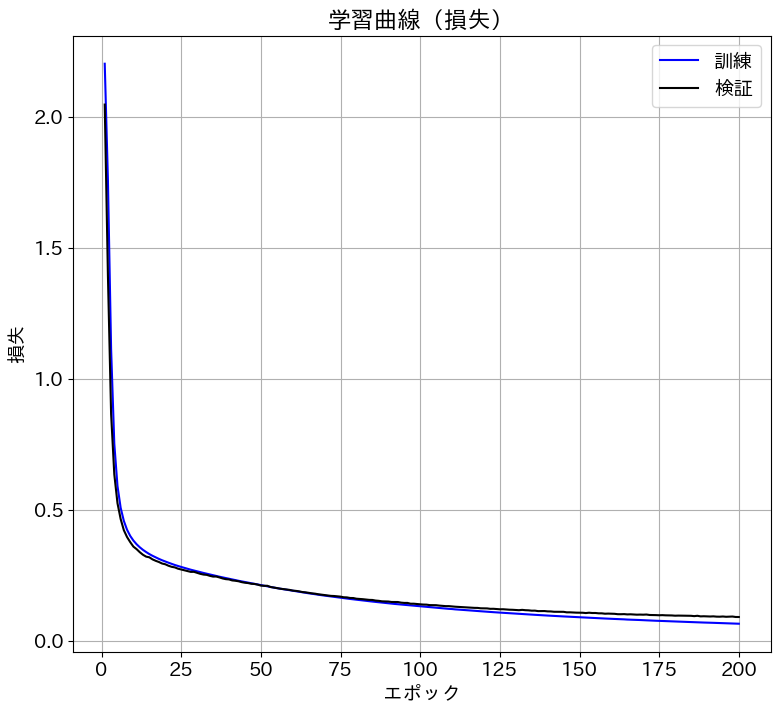

In [20]:
# 学習曲線の表示（損失）
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.legend()
plt.show()

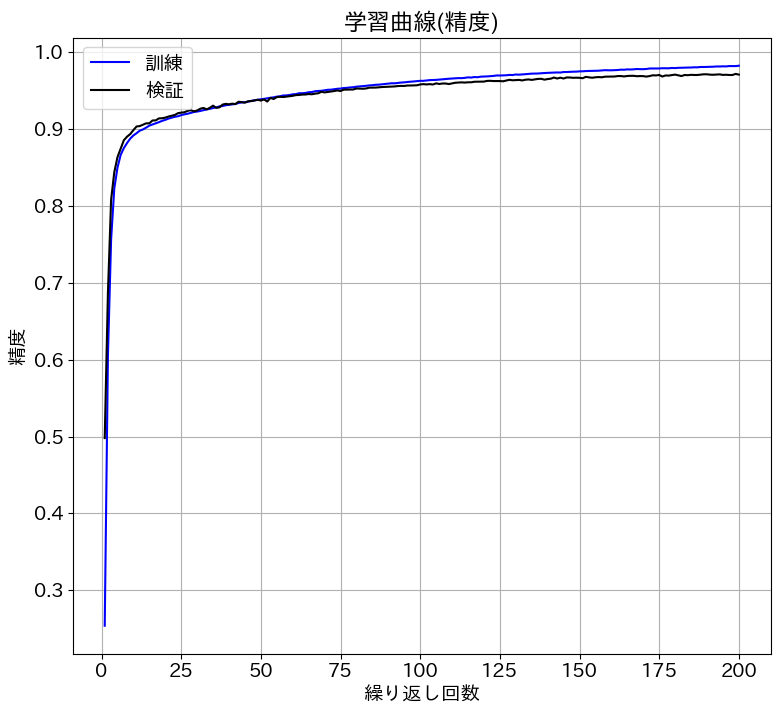

In [21]:
# 学習曲線の表示 (精度)
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

# イメージ表示で確認

In [22]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

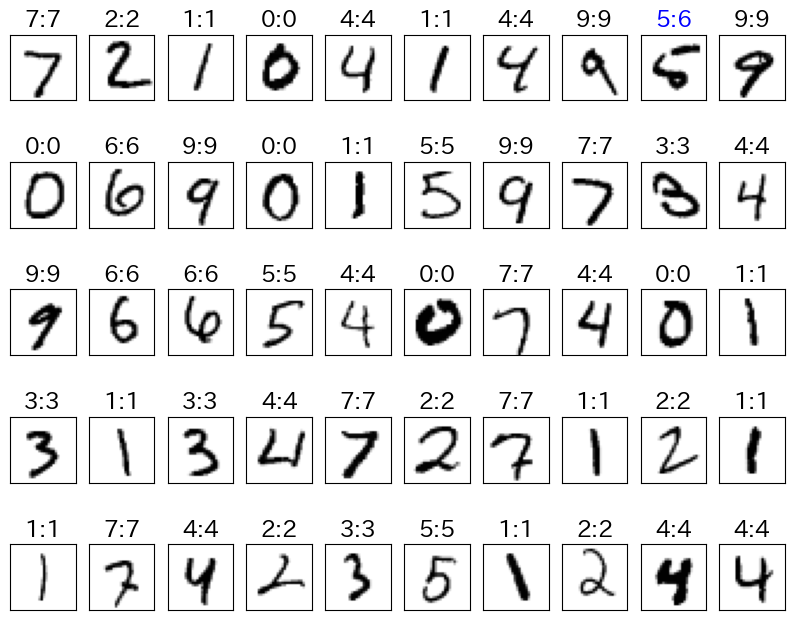

In [23]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2
    
  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()